In [3]:
from power_calculator import calculate_power
import os
import pandas as pd
from scrape_cardlists import DATA_PATH
BASE_PWR_PATH = os.path.join(DATA_PATH, "decks", "baseline")
MANUAL_SAVE = os.path.join(DATA_PATH, "decks", "manual_rand")
GPT_SAVE = os.path.join(DATA_PATH, "completed")
DECKS = os.path.join(DATA_PATH, "decks")

In [40]:
import os
import ast
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compile_power(directory):
    data = []  # To hold dictionaries from files
    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)  # Get the current folder name
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                #print(file_path)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    lines = f.readlines()
                    if lines:
                        try:
                            # Convert the last line to a dictionary
                            last_line_dict = ast.literal_eval(lines[-1].strip())
                            # Ensure it's actually a dictionary
                            if isinstance(last_line_dict, dict):
                                last_line_dict['folder'] = folder_name  # Add folder name to the dictionary
                                data.append(last_line_dict)
                        except (ValueError, SyntaxError):
                            print(f"Error processing file: {file_path}")
                            continue
    return pd.DataFrame(data)

# Replace 'path_to_your_directory' with the actual path to your directory
directory_path = 'path_to_your_directory'

df = compile_power(DECKS)
for col in df:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

df.head()

Error processing file: c:\Users\theod\edh-llm\data\decks\baseline\KambalConsulofAllocation.txt


,overall,cmc,ramp,draw,interaction,folder
0,3,3.646154,8,5,12,baseline
1,3,3.415385,5,21,16,baseline
2,8,2.909091,9,15,3,baseline
3,3,3.630769,1,7,8,baseline
4,3,3.636364,1,1,17,baseline


In [37]:
df.groupby('folder').mean()

,overall,cmc,ramp,draw,interaction
folder,,,,,
baseline,2.659794,2.778726,3.762887,8.917526,5.587629
gpt,5.948980,3.173241,9.142857,13.530612,8.295918
manual_rand,4.826531,3.183972,5.622449,12.244898,8.673469


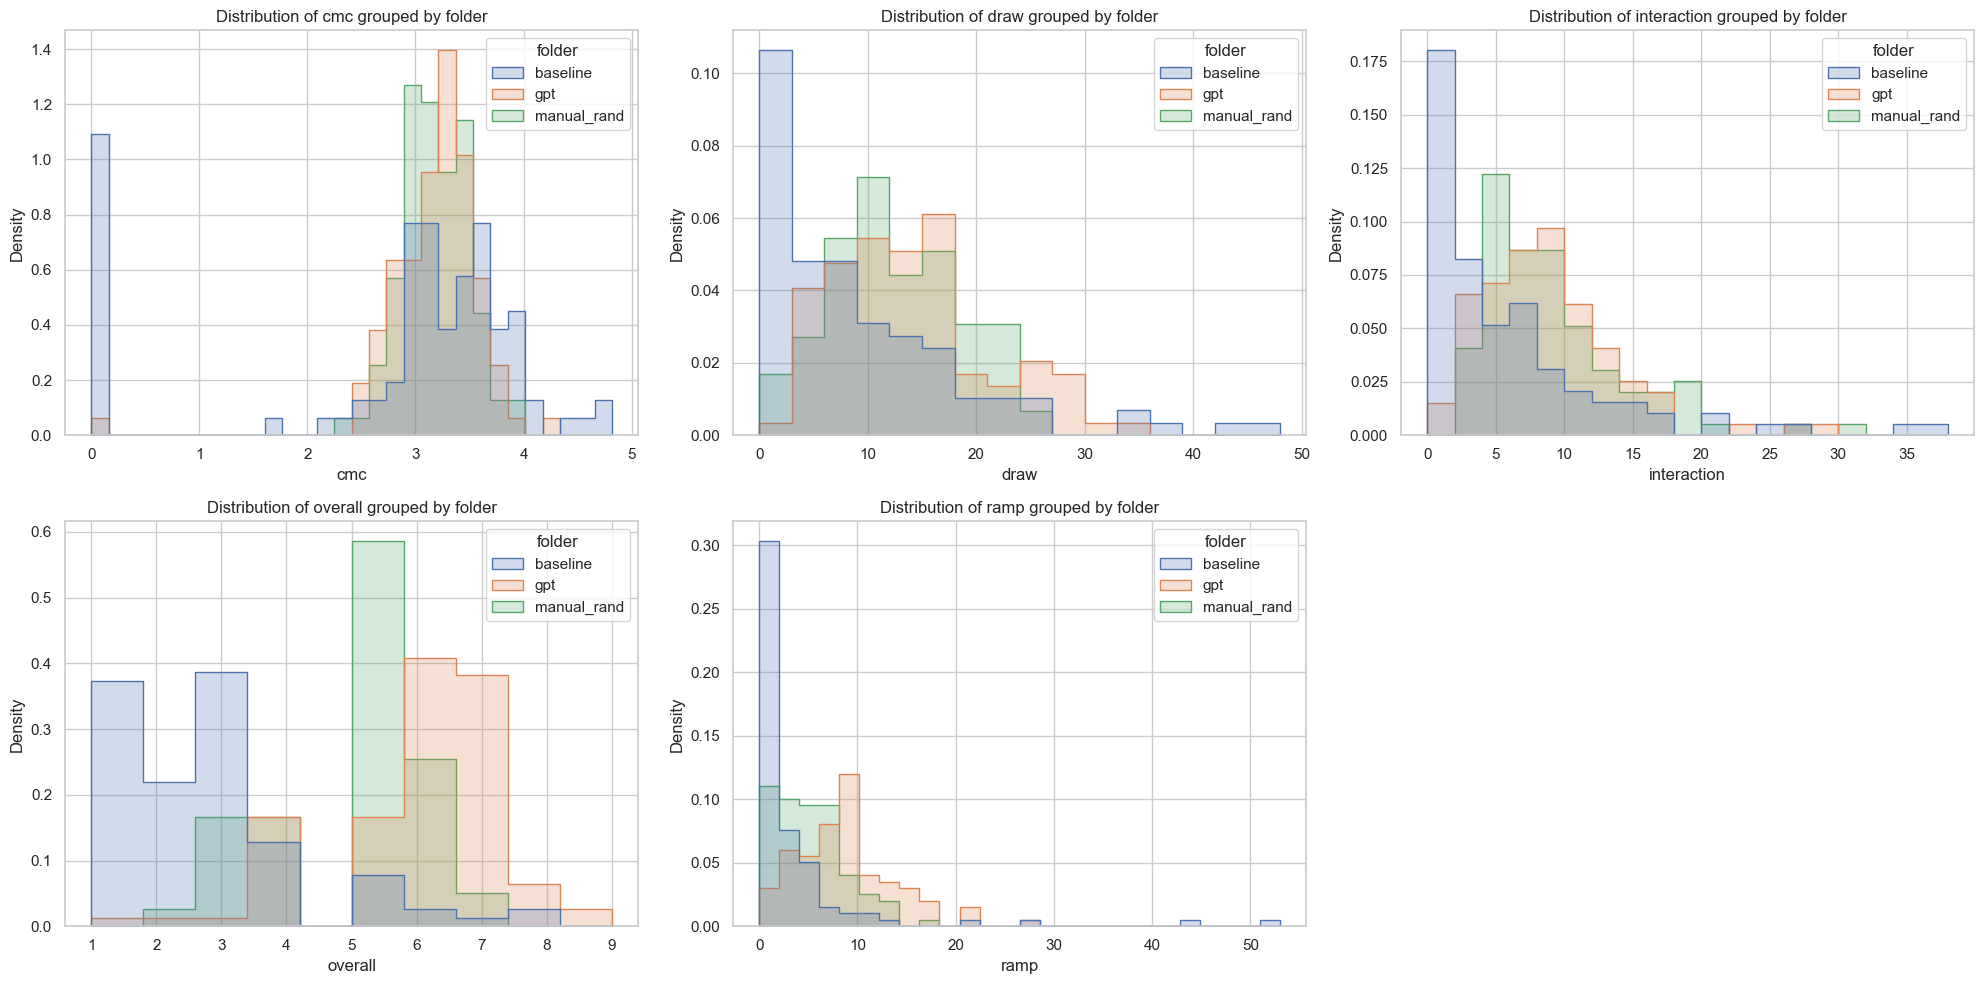

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Create a column list excluding 'folder'
columns = df.columns.difference(['folder'])

# Plotting
for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=column, hue="folder", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {column} grouped by folder')

plt.tight_layout()
plt.show()